In [3]:
import os, joblib, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Garantir que as pastas de saída existem
os.makedirs("../figures", exist_ok=True)
os.makedirs("../models", exist_ok=True)

# Configurações de estilo dos gráficos e da visualização de números
sns.set()
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")


In [4]:
from textwrap import dedent
print(dedent("""
PROBLEMA (Regressão): Prever o valor mediano de casas (MedHouseVal) em distritos da Califórnia
usando atributos socioeconômicos e geográficos do dataset California Housing.

ETL: Carregado do sklearn, tratamento simples, split treino/teste, padronização e pipeline.

Métricas: MAE, RMSE, R². Gráficos: histogramas, correlação, Real vs Previsto e resíduos.
"""))



PROBLEMA (Regressão): Prever o valor mediano de casas (MedHouseVal) em distritos da Califórnia
usando atributos socioeconômicos e geográficos do dataset California Housing.

ETL: Carregado do sklearn, tratamento simples, split treino/teste, padronização e pipeline.

Métricas: MAE, RMSE, R². Gráficos: histogramas, correlação, Real vs Previsto e resíduos.



In [5]:
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0000,6.9841,1.0238,322.0000,2.5556,37.8800,-122.2300,4.5260
1,8.3014,21.0000,6.2381,0.9719,"2,401.0000",2.1098,37.8600,-122.2200,3.5850
2,7.2574,52.0000,8.2881,1.0734,496.0000,2.8023,37.8500,-122.2400,3.5210
3,5.6431,52.0000,5.8174,1.0731,558.0000,2.5479,37.8500,-122.2500,3.4130
4,3.8462,52.0000,6.2819,1.0811,565.0000,2.1815,37.8500,-122.2500,3.4220


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [7]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
MedInc,"20,640.0000",3.8707,1.8998,0.4999,2.5634,3.5348,4.7432,15.0001
HouseAge,"20,640.0000",28.6395,12.5856,1.0000,18.0000,29.0000,37.0000,52.0000
AveRooms,"20,640.0000",5.4290,2.4742,0.8462,4.4407,5.2291,6.0524,141.9091
AveBedrms,"20,640.0000",1.0967,0.4739,0.3333,1.0061,1.0488,1.0995,34.0667
Population,"20,640.0000","1,425.4767","1,132.4621",3.0000,787.0000,"1,166.0000","1,725.0000","35,682.0000"
AveOccup,"20,640.0000",3.0707,10.3860,0.6923,2.4297,2.8181,3.2823,"1,243.3333"
Latitude,"20,640.0000",35.6319,2.1360,32.5400,33.9300,34.2600,37.7100,41.9500
Longitude,"20,640.0000",-119.5697,2.0035,-124.3500,-121.8000,-118.4900,-118.0100,-114.3100
MedHouseVal,"20,640.0000",2.0686,1.1540,0.1500,1.1960,1.7970,2.6472,5.0000


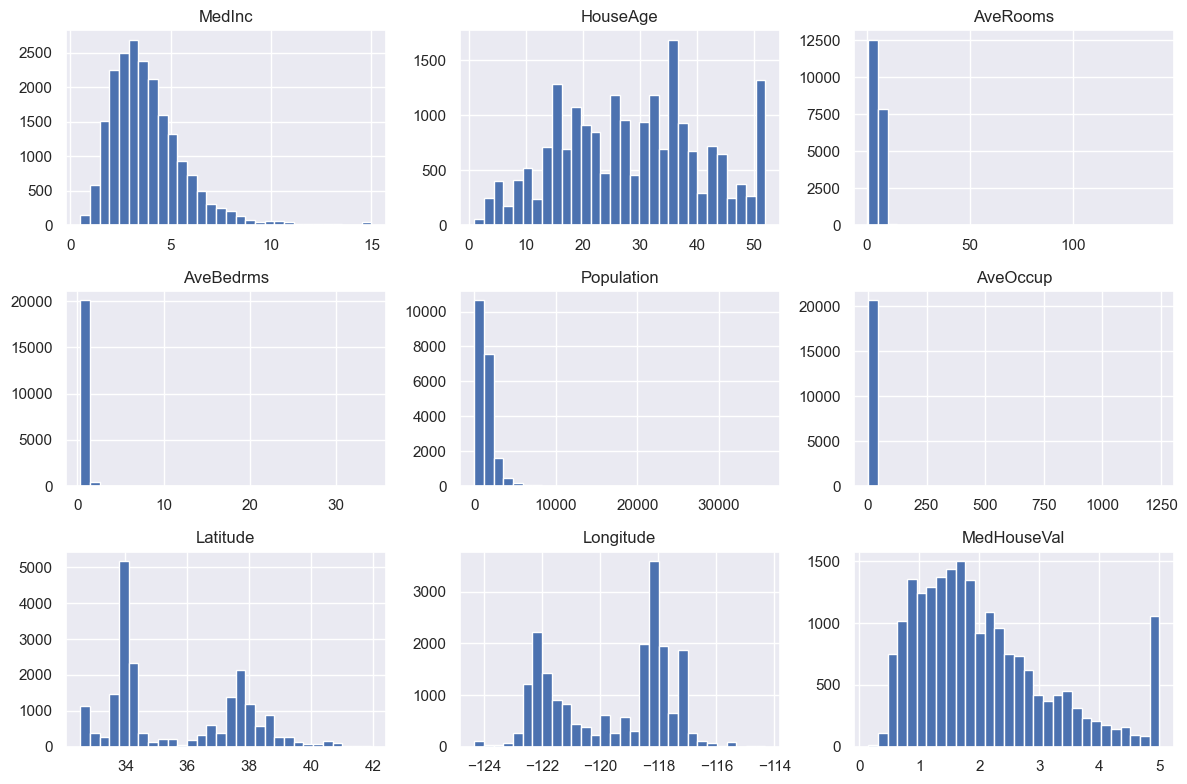

In [8]:
df.hist(bins=30, figsize=(12,8))
plt.tight_layout()
plt.savefig("../figures/california_hist.png", dpi=120)
plt.show()


In [9]:
# Separar features (X) e alvo (y)
X = df.drop(columns=["MedHouseVal"])
y = df["MedHouseVal"]

# Todas as colunas são numéricas nesse dataset
num_features = X.columns.tolist()

# Pré-processamento: padronizar (média 0, desvio 1)
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features)
    ],
    remainder="drop"  # ignora qualquer coluna que não estiver na lista
)

# Modelo: Regressão Linear
model = LinearRegression()

# Pipeline: primeiro preprocessa, depois treina o modelo
pipeline = Pipeline(steps=[
    ("prep", preprocess),
    ("model", model)
])

# Dividir em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

len(X_train), len(X_test)


(16512, 4128)

In [10]:
# Treinar o pipeline no conjunto de treino
pipeline.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = pipeline.predict(X_test)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:,.3f}")
print(f"RMSE: {rmse:,.3f}")
print(f"R²:   {r2:,.3f}")


TypeError: got an unexpected keyword argument 'squared'

In [12]:
# Treinar o pipeline no conjunto de treino
pipeline.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = pipeline.predict(X_test)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)

# Em versões mais antigas do scikit-learn não existe o parâmetro squared=False
mse = mean_squared_error(y_test, y_pred)  # MSE normal
rmse = np.sqrt(mse)                       # RMSE = raiz do MSE

r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:,.3f}")
print(f"RMSE: {rmse:,.3f}")
print(f"R²:   {r2:,.3f}")


print(f"MAE:  {mae:,.3f}")
print(f"RMSE: {rmse:,.3f}")
print(f"R²:   {r2:,.3f}")


MAE:  0.533
RMSE: 0.746
R²:   0.576
MAE:  0.533
RMSE: 0.746
R²:   0.576


In [13]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(pipeline, X, y, cv=cv, scoring="r2")

print("R² CV (média ± desvio):", f"{cv_r2.mean():.3f} ± {cv_r2.std():.3f}")


R² CV (média ± desvio): 0.601 ± 0.017


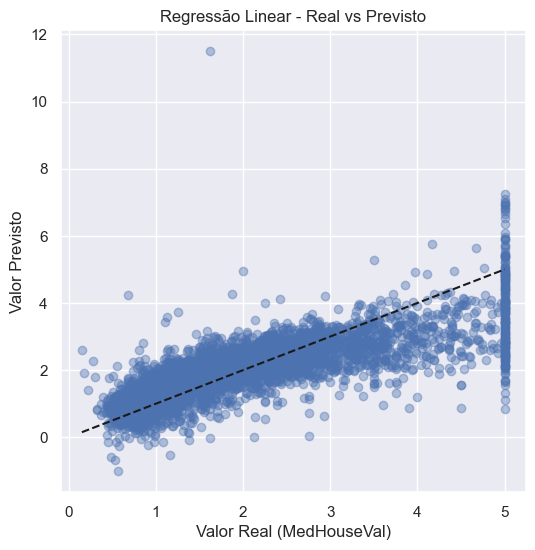

In [14]:
# Gráfico Real vs Previsto
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Valor Real (MedHouseVal)")
plt.ylabel("Valor Previsto")
plt.title("Regressão Linear - Real vs Previsto")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "k--")  # linha diagonal de referência
plt.savefig("../figures/lin_real_vs_pred.png", dpi=120, bbox_inches="tight")
plt.show()


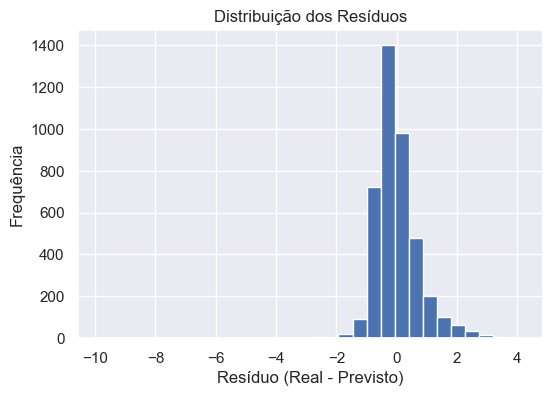

In [15]:
# Cálculo dos resíduos (erro = real - previsto)
residuos = y_test - y_pred

plt.figure(figsize=(6,4))
plt.hist(residuos, bins=30)
plt.title("Distribuição dos Resíduos")
plt.xlabel("Resíduo (Real - Previsto)")
plt.ylabel("Frequência")
plt.savefig("../figures/lin_residuos.png", dpi=120, bbox_inches="tight")
plt.show()


In [16]:
# Salvar o pipeline completo (pré-processamento + modelo) em arquivo
joblib.dump(pipeline, "../models/regressao_linear_california.pkl")

print("Modelo salvo em '../models/regressao_linear_california.pkl'")


Modelo salvo em '../models/regressao_linear_california.pkl'


### Análise dos Resultados – Regressão Linear (California Housing)

O objetivo deste experimento foi prever o valor mediano das casas (`MedHouseVal`) em distritos da Califórnia utilizando um modelo de **Regressão Linear**, integrado a um pipeline com padronização das variáveis (`StandardScaler`). O dataset foi dividido em 80% para treino e 20% para teste.

Nos dados de teste, o modelo apresentou os seguintes resultados:

- **MAE:** 0.533  
- **RMSE:** 0.746  
- **R²:** 0.576  

Esses valores indicam que o modelo consegue explicar aproximadamente **57,6% da variabilidade** do valor das casas. O MAE e o RMSE mostram que o erro médio das previsões é relativamente baixo, considerando a escala dos dados.

Para avaliar a estabilidade e a capacidade de generalização do modelo, foi aplicada uma **validação cruzada com 5 folds**, resultando em:

- **R² médio:** 0.601  
- **Desvio padrão:** 0.017  

Esses resultados mostram que o modelo apresenta **consistência** entre diferentes divisões dos dados, com pouca variação entre os folds. O R² médio da validação cruzada sendo ligeiramente superior ao R² do teste indica que o desempenho é estável e sem sinais de overfitting significativo.

Os gráficos de diagnóstico também reforçam essas conclusões:

- O gráfico **Real vs Previsto** apresentou uma dispersão de pontos próxima à linha diagonal, indicando boa aderência às tendências dos valores reais.
- A **distribuição dos resíduos** mostrou erros distribuídos ao redor de zero, o que é um bom indício de que o modelo não apresenta padrões sistemáticos de erro.

Apesar disso, ainda há variabilidade não explicada pelo modelo, sugerindo que abordagens mais flexíveis — como **Random Forest**, **Gradient Boosting** ou **XGBoost** — poderiam capturar melhor relações não lineares entre as variáveis e melhorar o desempenho.

Por fim, o pipeline completo (pré-processamento + modelo) foi salvo no arquivo `regressao_linear_california.pkl`, permitindo reaplicar o modelo treinado em novos dados sem a necessidade de retreino.

